# Solving the Eight-Queen problem using Genetic Algorithms

_Assignment for the University of Bath as part of MSc in Artificial Intelligence_ 

## Eight-Queen Genetic Algorithm

### Problem set up

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import timeit

In [2]:
class EightQueensState:

    """This class represents a board in the eight queens puzzle"""

    def __init__(self, state=None, n=8):
        """
        :param state: pass in a numpy array of integers to set the state, otherwise will be generated randomly
        :param n: only used if state is not provided, determines size of board (default: 8)
        """
        if state is None:
            self.n = n
            state = np.random.randint(0, n, n)
        else:
            self.n = len(state)
        self.state = state

    @staticmethod
    def copy_replace(state, i, x):
        """This creates a copy of the state (important as numpy arrays are mutable) with column i set to x"""
        new_state = state.copy()
        new_state[i] = x
        return new_state

    @staticmethod
    def range_missing(start, stop, missing):
        """
        This creates a list of numbers with a single value missing
        e.g. range_missing(0, 8, 2) -> [0, 1, 3, 4, 5, 6, 7]
        """
        return list(range(start, missing)) + list(range(missing + 1, stop))

    def cost(self):
        """Calculates the number of pairs attacking"""
        count = 0
        for i in range(len(self.state) - 1):
            # for each queen, look in columns to the right
            # add one to the count if there is another queen in the same row
            # a pair of attacking queens only adds one to the count, not 2 as per Lesson 2 notes
            count += (self.state[i] == np.array(self.state[i + 1:])).sum()

            # add one to the count for each queen on the upper or lower diagonal
            upper_diagonal = self.state[i] + np.arange(1, self.n - i)
            lower_diagonal = self.state[i] - np.arange(1, self.n - i)
            count += (np.array(self.state[i + 1:]) == upper_diagonal).sum()
            count += (np.array(self.state[i + 1:]) == lower_diagonal).sum()
        return count

    def neighbourhood(self):
        """This generates every state possible by changing a single queen position"""
        neighbourhood = []
        for column in range(self.n):
            for new_position in self.range_missing(0, self.n, self.state[column]):
                new_state = self.copy_replace(self.state, column, new_position)
                neighbourhood.append(EightQueensState(new_state))

        return neighbourhood

    def random_neighbour(self):
        """Generates a single random neighbour state, useful for some algorithms"""
        column = np.random.choice(range(self.n))
        new_position = np.random.choice(self.range_missing(0, self.n, self.state[column]))
        new_state = self.copy_replace(self.state, column, new_position)
        return EightQueensState(new_state)

    def is_goal(self):
        return self.cost() == 0

    def __str__(self):
        return self.state

### Genetic Algorithm class set up

This class defines the methods which a genetic algorithm applies, including parent selection (based on fitness), crossover and mutation. Population size and mutation rate are variable inputs, set to 10 and 5% initially. The number of queens is also variable but is set to 8 for the initial task.

In [3]:
class EightQueensGeneticAlgorithm:

    def __init__(self, initial_population_size=10, number_queens=8, mutation_rate=0.05):
        self.initial_population_size = initial_population_size
        self.number_queens = number_queens
        self.mutation_rate = mutation_rate
        self.initial_population = [EightQueensState(n=number_queens) for _ in range(self.initial_population_size)]
        self.population_states = [state.state for state in self.initial_population]

    def fitness_function(self, population):
        fitness_array = [((self.number_queens * (self.number_queens - 1)) / 2) - state.cost() for state in population]
        fitness_array = np.array(fitness_array)
        fitness_array = fitness_array/sum(fitness_array)
        return fitness_array

    def parent_selection(self, population_states, fitness_array):
        # mixing number = 2, ie. offspring from exactly 2 parents
        # parents are only selected from 50% of fittest individuals
        parent_list = []
        d = {"population": population_states, "fitness": fitness_array}
        df = pd.DataFrame(d)
        df.sort_values(by=["fitness"], inplace=True, ascending=False)
        df.reset_index(drop=True, inplace=True)
        n = int(np.ceil(len(df)) / 2)
        fittest_population = df.head(n)
        relative_fitness = np.array(fittest_population["fitness"])
        relative_fitness = relative_fitness/sum(relative_fitness)
        while len(parent_list) < np.ceil(len(population_states) / 2):
            parent_list.append(np.random.choice(fittest_population["population"], 
                                                size=2, replace=False, p=list(relative_fitness)))
        return parent_list

    def crossover(self, parent_list):
        # each set of parents has 2 offspring to keep population constant
        child_list = []
        for parents in parent_list:
            partition_point = random.randint(1, len(parents[0]) - 1)
            child_1 = np.concatenate((parents[0][0:partition_point], parents[1][partition_point:]))
            child_2 = np.concatenate((parents[1][0:partition_point], parents[0][partition_point:]))
            child_list.append(child_1)
            child_list.append(child_2)
        return child_list

    def mutate(self, child_list):
        mutated_list = []
        for child in child_list:
            post_mutation_child = []
            for gene in child:
                if random.choices([0, 1], weights=[1-self.mutation_rate, self.mutation_rate])[0] == 1:
                    post_mutation_child.append(random.randint(0, self.number_queens-1))
                else:
                    post_mutation_child.append(gene)
            mutated_list.append(post_mutation_child)
        return mutated_list

    def next_generation(self, mutated_list):
        next_generation = [EightQueensState(state=np.array(child)) for child in mutated_list]
        return next_generation

### Run Genetic Algorithm to solve 8 queens problem

The code below runs the genetic algorithm for up to 2000 generations or until a solution is found. The code outputs the solution if found along with a graph showing the average population fitness in each generation to show how this increases over time.

Random seeds are set to 1 but these lines can be deleted to run the algorithm on a random population.

In [4]:
def run_genetic_algorithm(ga, max_generations):
    generation_count = 1
    average_fitness_list = []
    while generation_count < max_generations:
        fitness_list = []
        for state in ga.initial_population:
            if state.cost() == 0:
                return state.state, state.cost(), generation_count, average_fitness_list
            else:
                fitness_list.append((ga.number_queens * (ga.number_queens - 1) / 2) - state.cost())
        average_fitness_list.append(np.mean(fitness_list))
        population_fitness = ga.fitness_function(ga.initial_population)
        parents = ga.parent_selection(ga.population_states, population_fitness)
        children = ga.crossover(parents)
        children = ga.mutate(children)
        next_gen = ga.next_generation(children)
        ga.initial_population = next_gen
        ga.population_states = [state.state for state in next_gen]
        generation_count += 1
    return "No solution found", "No solution found", generation_count, average_fitness_list

Solution state = [3 1 6 4 0 7 5 2]
Solution cost (pairs of attacking queens) = 0
Number of generations = 265


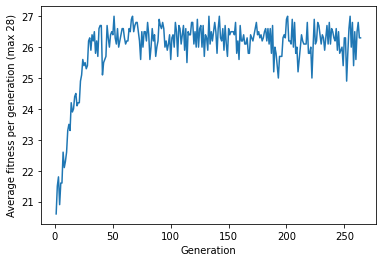

In [5]:
random.seed(1)
np.random.seed(1)

ga = EightQueensGeneticAlgorithm()
solution_state, cost, generation_count, average_fitness_list = run_genetic_algorithm(ga, 2000)
print(f"Solution state = {solution_state}")
print(f"Solution cost (pairs of attacking queens) = {cost}")
print(f"Number of generations = {generation_count}")
plt.plot([n for n in range(1, generation_count)], average_fitness_list)
plt.ylabel("Average fitness per generation (max 28)")
plt.xlabel("Generation")
plt.show()

## Optimisations and Extensions

### Variable Optimisation - Mutation Rate

The code below runs 20 simulations (starting with a random population each time) of the Genetic Algorithm for various mutation rates, holding population size constant. The mutation rate starts at 0% and increases to 100% in increments of 5%, with the results plotted.

In [6]:
def mutation_rate_tester(population_size, max_generations, simulations):
    mutation_rate = 0.00
    mutation_rate_list = []
    average_time_list = []
    setup_code = """
import numpy as np
import random
import pandas as pd
from __main__ import run_genetic_algorithm
from __main__ import EightQueensGeneticAlgorithm"""
    while mutation_rate <= 1:
        test_code = f"run_genetic_algorithm(EightQueensGeneticAlgorithm(initial_population_size={population_size}, mutation_rate={mutation_rate}), {max_generations})"
        time = timeit.timeit(setup=setup_code, stmt=test_code, number=simulations)
        average_time = time/simulations
        average_time_list.append(average_time)
        mutation_rate_list.append(mutation_rate)
        mutation_rate += 0.05
    return mutation_rate_list, average_time_list

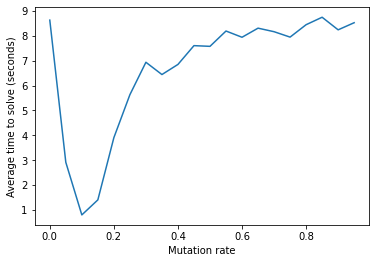

In [7]:
mutation_rate_list, average_time_list = mutation_rate_tester(10, 2000, 20)
plt.plot(mutation_rate_list, average_time_list)
plt.ylabel("Average time to solve (seconds)")
plt.xlabel("Mutation rate")
plt.show()

### Variable Optimisation - Population Size

A similar process is followed for population size, holding mutation rate constant at 10% (the optimal value shown in the graph above).

In [8]:
def population_size_tester(mutation_rate, max_generations, simulations):
    population_size = 5
    population_size_list = []
    average_time_list = []
    setup_code = """
import numpy as np
import random
import pandas as pd
from __main__ import run_genetic_algorithm
from __main__ import EightQueensGeneticAlgorithm"""
    while population_size <= 100:
        test_code = f"run_genetic_algorithm(EightQueensGeneticAlgorithm(initial_population_size={population_size}, mutation_rate={mutation_rate}), {max_generations})"
        time = timeit.timeit(setup=setup_code, stmt=test_code, number=simulations)
        average_time = time/simulations
        average_time_list.append(average_time)
        population_size_list.append(population_size)
        population_size += 5
    return population_size_list, average_time_list

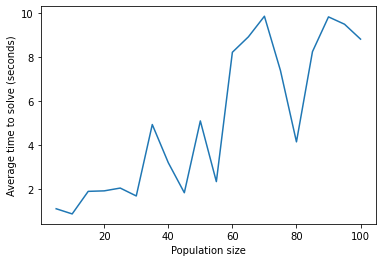

In [16]:
population_size_list, average_time_list = population_size_tester(0.1, 2000, 20)
plt.plot(population_size_list, average_time_list)
plt.ylabel("Average time to solve (seconds)")
plt.xlabel("Population size")
plt.show()

These results show that a mutation rate of 10% and population of 10 give the lowest average time to solve the problem. Therefore these values will be used going forward.

### Minimal conflicts algorithm and Extension to N Queens

First, setting up the minimal conflicts genetic algorithm and comparing this with the standard genetic algorithm for the case of 8 queens:

In [10]:
def minimal_conflicts(next_generation_list):
    updated_next_generation_list = []
    for child in next_generation_list:
        neighbourhood = child.neighbourhood()
        fittest_state = child
        for state in neighbourhood:
            if state.cost() < fittest_state.cost():
                fittest_state = state
        updated_next_generation_list.append(fittest_state)
    return updated_next_generation_list


def run_ga_min_conflicts(ga, max_generations):
    generation_count = 1
    average_fitness_list = []
    while generation_count < max_generations:
        fitness_list = []
        for state in ga.initial_population:
            if state.cost() == 0:
                return state.state, state.cost(), generation_count, average_fitness_list
            else:
                fitness_list.append((ga.number_queens * (ga.number_queens - 1) / 2) - state.cost())
        average_fitness_list.append(np.mean(fitness_list))
        population_fitness = ga.fitness_function(ga.initial_population)
        parents = ga.parent_selection(ga.population_states, population_fitness)
        children = ga.crossover(parents)
        children = ga.mutate(children)
        next_gen = ga.next_generation(children)
        min_conflicts_next_gen = minimal_conflicts(next_gen)
        ga.initial_population = min_conflicts_next_gen
        ga.population_states = [state.state for state in min_conflicts_next_gen]
        generation_count += 1
    return "No solution found", "No solution found", generation_count, average_fitness_list


def algorithm_comparison(population_size, mutation_rate, max_generations, simulations):
    setup_code = """
import numpy as np
import random
import pandas as pd
from __main__ import run_genetic_algorithm
from __main__ import minimal_conflicts
from __main__ import run_ga_min_conflicts
from __main__ import EightQueensGeneticAlgorithm"""
    test_code_1 = f"run_genetic_algorithm(EightQueensGeneticAlgorithm(initial_population_size={population_size}, mutation_rate={mutation_rate}), {max_generations})"
    time1 = timeit.timeit(setup=setup_code, stmt=test_code_1, number=simulations)
    average_time1 = time1/simulations
    test_code_2 = f"run_ga_min_conflicts(EightQueensGeneticAlgorithm(initial_population_size={population_size}, mutation_rate={mutation_rate}), {max_generations})"
    time2 = timeit.timeit(setup=setup_code, stmt=test_code_2, number=simulations)
    average_time2 = time2/simulations
    return average_time1, average_time2

In [17]:
random.seed(2)
np.random.seed(2)

ga_time, ga_min_conflicts_time = algorithm_comparison(10, 0.1, 2000, 100)
print(f"Genetic Algorithm - Average time to find a solution = {ga_time} seconds")
print(f"Genetic Algorithm plus minimum conflicts - Average time to find a solution = {ga_min_conflicts_time} seconds")

Genetic Algorithm - Average time to find a solution = 0.9501775109999926 seconds
Genetic Algorithm plus minimum conflicts - Average time to find a solution = 3.5728948820000004 seconds


From this result, it seems as though the added time required to run the min_conflicts code increases the time taken to find a solution. However, this code becomes useful when extending the problem to the case of >8 queens.

Trialling both algorithms for different values of N in the N queens problem to give a side-by-side comparison.

In [18]:
def algorithm_comparison_n_queens(number_queens, population_size, mutation_rate, max_generations):
    ga_solution, ga_cost, ga_generation_count, ga_average_fitness_list = run_genetic_algorithm(EightQueensGeneticAlgorithm(initial_population_size=population_size, number_queens=number_queens, mutation_rate=mutation_rate), max_generations)
    ga_min_conflicts_solution, ga_min_conflicts_cost, ga_min_conflicts_generation_count, ga_min_conflicts_average_fitness_list = run_ga_min_conflicts(EightQueensGeneticAlgorithm(initial_population_size=population_size, number_queens=number_queens, mutation_rate=mutation_rate), max_generations)
    setup_code = """
import numpy as np
import random
import pandas as pd
from __main__ import run_genetic_algorithm
from __main__ import minimal_conflicts
from __main__ import run_ga_min_conflicts
from __main__ import EightQueensGeneticAlgorithm"""
    test_code_1 = f"run_genetic_algorithm(EightQueensGeneticAlgorithm(initial_population_size={population_size}, number_queens={number_queens}, mutation_rate={mutation_rate}), {max_generations})"
    ga_time = timeit.timeit(setup=setup_code, stmt=test_code_1, number=1)
    test_code_2 = f"run_ga_min_conflicts(EightQueensGeneticAlgorithm(initial_population_size={population_size}, number_queens={number_queens}, mutation_rate={mutation_rate}), {max_generations})"
    ga_min_conflicts_time = timeit.timeit(setup=setup_code, stmt=test_code_2, number=1)
    return number_queens, ga_solution, ga_min_conflicts_solution, ga_time, ga_min_conflicts_time

In [20]:
random.seed(3)
np.random.seed(3)

result_df = pd.DataFrame(columns=["Number of queens", "GA solution", "GA + min conflicts solution", "GA time (seconds)", "GA + min conflicts time (seconds)"])
for i in range(4, 16):
    number_queens, ga_solution, ga_min_conflicts_solution, ga_time, ga_min_conflicts_time = algorithm_comparison_n_queens(i, 10, 0.1, 10000)
    row = pd.Series([number_queens, ga_solution, ga_min_conflicts_solution, ga_time, ga_min_conflicts_time], index=result_df.columns)
    result_df = result_df.append(row, ignore_index=True)
    
result_df

,Number of queens,GA solution,GA + min conflicts solution,GA time (seconds),GA + min conflicts time (seconds)
0,4,"[2, 0, 3, 1]","[2, 0, 3, 1]",0.019599,0.013649
1,5,"[4, 2, 0, 3, 1]","[2, 4, 1, 3, 0]",0.026620,0.056507
2,6,"[1, 3, 5, 0, 2, 4]","[3, 0, 4, 1, 5, 2]",5.074497,0.099375
3,7,"[5, 1, 4, 0, 3, 6, 2]","[0, 3, 6, 2, 5, 1, 4]",0.047681,0.403888
4,8,"[4, 2, 0, 5, 7, 1, 3, 6]","[4, 1, 3, 6, 2, 7, 5, 0]",0.419696,13.206275
5,9,"[4, 2, 7, 5, 1, 8, 0, 3, 6]","[6, 1, 3, 5, 0, 8, 4, 2, 7]",1.846944,7.889747
6,10,"[4, 6, 0, 3, 5, 8, 2, 9, 7, 1]","[5, 1, 9, 0, 6, 3, 7, 2, 4, 8]",8.128973,2.505483
7,11,No solution found,"[5, 9, 4, 1, 8, 6, 2, 10, 7, 0, 3]",7.070955,6.384094
8,12,No solution found,"[5, 2, 11, 3, 8, 4, 9, 1, 10, 7, 0, 6]",37.645042,45.170720
9,13,No solution found,"[10, 5, 11, 8, 0, 2, 9, 7, 1, 3, 12, 6, 4]",67.732579,13.116163
